In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

In [ ]:
cd /content/drive/MyDrive/weather_bigdata_contest/code/

/content/drive/MyDrive/weather_bigdata_contest/code


In [ ]:
sale_data_df = pd.read_csv('../data/sale_data_ohe.csv')

In [ ]:
orange_sale_data_df = sale_data_df[sale_data_df['소분류_감귤/한라봉/오렌지'] == 1]

In [ ]:
orange_sale_data_df.reset_index(drop = True, inplace = True)

In [ ]:
orange_sale_data_df[['날짜', '일별 판매 합계량(개)']]

,날짜,일별 판매 합계량(개)
0,2018-01-01,885.0
1,2018-01-02,1021.0
2,2018-01-03,1009.0
3,2018-01-04,880.0
4,2018-01-05,1080.0
...,...,...
695,2019-12-27,1308.0
696,2019-12-28,1543.0
697,2019-12-29,1425.0
698,2019-12-30,1481.0


In [ ]:
weather_data_df = pd.read_csv('../data/weather_data.csv', encoding = 'CP949')

In [ ]:
weather_data_df = weather_data_df[['일시', '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '최소 상대습도(%)', '평균 상대습도(%)', 'O3', 'PM10']]

In [ ]:
# 병합하려고 했는데 날짜 column name이 달라서 '날짜'로 통일
weather_data_df.rename(columns = {'일시':'날짜'}, inplace = True)

In [ ]:
# pandas의 merge_asof method 사용하여 '날짜'를 기준으로 합치는 방법 사용하려고 했는데, '날짜'의 type이 str이라서 integer나 float으로 변경 필요
# pandas의 to_datetime method를 사용하여 type 변경
orange_sale_data_df['날짜'] = pd.to_datetime(orange_sale_data_df['날짜'], format='%Y-%m-%d')
orange_sale_data_df = orange_sale_data_df.sort_values('날짜')
weather_data_df['날짜'] = pd.to_datetime(weather_data_df['날짜'], format = '%Y-%m-%d')
weather_data_df = weather_data_df.sort_values('날짜')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# df 순서를 바꾸면 안됨
orange_df = pd.merge_asof(orange_sale_data_df, weather_data_df, on='날짜', allow_exact_matches=True)

In [ ]:
orange_df.head()

,날짜,대분류_냉난방가전,대분류_뷰티,대분류_식품,소분류_가공란,소분류_가스온수기,소분류_가열식 가습기,소분류_가자미,소분류_갈비/찜/바비큐용 돈육,소분류_갈비용 우육,소분류_갈치,소분류_감/홍시,소분류_감귤/한라봉/오렌지,소분류_감마리놀렌산 영양제,소분류_감말랭이,소분류_감자,소분류_갓김치,소분류_건강즙,소분류_건강즙/녹용,소분류_건대추,소분류_건망고,소분류_건바나나,소분류_건어물 건새우,소분류_건어물 노가리,소분류_건어물 마른오징어,소분류_건어물 멸치,소분류_건어물 쥐포,소분류_건어물 진미채,소분류_건어물 황태,소분류_건자두,소분류_건포도,소분류_게장류,소분류_견과류,소분류_견과류 땅콩,소분류_견과류 마카다미아,소분류_견과류 밤,소분류_견과류 잣/은행,소분류_견과류 카카오닙스,소분류_견과류 캐슈넛,소분류_견과류 피스타치오,...,소분류_홍삼절편/홍삼정과,소분류_홍어,소분류_홍차,소분류_화장 비누,소분류_화장 퍼프,소분류_환자식,소분류_황토매트,소분류_회,소분류_휴대용 선풍기,소분류_흰우유,소분류_히터,20대 남성 판매량(개),20대 여성 판매량(개),30대 남성 판매량(개),30대 여성 판매량(개),40대 남성 판매량(개),40대 여성 판매량(개),50대 남성 판매량(개),50대 여성 판매량(개),60대 남성 판매량(개),60대 여성 판매량(개),일별 판매 합계량(개),일별 물품 선호도 점수,20대 남성 선호도 점수,20대 여성 선호도 점수,30대 남성 선호도 점수,30대 여성 선호도 점수,40대 남성 선호도 점수,40대 여성 선호도 점수,50대 남성 선호도 점수,50대 여성 선호도 점수,60대 남성 선호도 점수,60대 여성 선호도 점수,평균기온(°C),최저기온(°C),최고기온(°C),최소 상대습도(%),평균 상대습도(%),O3,PM10
0,2018-01-01,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,33.0,105.0,68.0,179.0,99.0,223.0,43.0,104.0,7.0,22.0,885.0,0.000230,0.081053,0.087105,0.077665,0.082657,0.120986,0.125849,0.107601,0.136987,0.054336,0.125761,0.066157,-3.463993,4.734708,20.763179,41.267581,0.015544,44.032069
1,2018-01-02,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,21.0,82.0,86.0,211.0,119.0,275.0,62.0,132.0,15.0,16.0,1021.0,0.000265,0.044743,0.059008,0.085205,0.084519,0.126152,0.134625,0.134582,0.150823,0.101002,0.079340,-0.000201,-3.617037,4.293367,25.960511,47.229263,0.013179,53.742579
2,2018-01-03,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,30.0,68.0,88.0,212.0,139.0,252.0,48.0,129.0,10.0,31.0,1009.0,0.000273,0.062158,0.047586,0.084785,0.082581,0.143296,0.119968,0.101323,0.143336,0.065480,0.149487,-2.328937,-4.948951,1.733667,27.184564,39.916465,0.017566,34.601134
3,2018-01-04,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,13.0,51.0,76.0,211.0,118.0,237.0,55.0,95.0,9.0,13.0,880.0,0.000217,0.033847,0.044848,0.092013,0.103283,0.152863,0.141780,0.145891,0.132645,0.074055,0.078775,-2.419582,-6.149132,1.320985,31.627278,44.077518,0.011983,42.672343
4,2018-01-05,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,38.0,58.0,81.0,250.0,89.0,301.0,51.0,159.0,16.0,35.0,1080.0,0.000297,0.072388,0.037317,0.071751,0.089535,0.084356,0.131746,0.098979,0.162431,0.096324,0.155173,-0.734189,-3.487800,3.788739,30.797391,50.195533,0.011894,51.988526


In [ ]:
orange_df = orange_df[['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '최소 상대습도(%)', '평균 상대습도(%)', 'O3', 'PM10', '일별 판매 합계량(개)' ]]

In [ ]:
orange_df.head()

,평균기온(°C),최저기온(°C),최고기온(°C),최소 상대습도(%),평균 상대습도(%),O3,PM10,일별 판매 합계량(개)
0,0.066157,-3.463993,4.734708,20.763179,41.267581,0.015544,44.032069,885.0
1,-0.000201,-3.617037,4.293367,25.960511,47.229263,0.013179,53.742579,1021.0
2,-2.328937,-4.948951,1.733667,27.184564,39.916465,0.017566,34.601134,1009.0
3,-2.419582,-6.149132,1.320985,31.627278,44.077518,0.011983,42.672343,880.0
4,-0.734189,-3.487800,3.788739,30.797391,50.195533,0.011894,51.988526,1080.0


In [ ]:
def data_preparation(df, days_before):
    #7일치의 날씨와 판매량을 통해 8일차의 판매량 예측
    #X=7일치 날씨와 판매량
    #Y=8일차의 판매량
    temp = df.values
    X = []
    y = []
    for i in range(len(df) - days_before):
        X.append(temp[i:i + days_before])
        y.append(temp[i + days_before, -1])
    split_len = int(len(X) * 0.7)
    X_train = np.array(X[:split_len])
    X_test = np.array(X[split_len:])
    y_train = np.array(y[:split_len])
    y_test = np.array(y[split_len:])
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = data_preparation(orange_df, days_before=7)

In [ ]:
np.array(X_train).shape

(485, 7, 8)

In [ ]:
np.array(y_train).shape

(485,)

In [ ]:
np.array(X_test).shape

(208, 7, 8)

In [ ]:
np.array(y_test).shape

(208,)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 7, validation_data = (X_test, y_test), shuffle = False)

Epoch 1/100
70/70 [==============================] - 3s 14ms/step - loss: 934708.6562 - val_loss: 885979.3125
Epoch 2/100
70/70 [==============================] - 0s 5ms/step - loss: 932574.4696 - val_loss: 882996.5625
Epoch 3/100
70/70 [==============================] - 0s 6ms/step - loss: 929070.2324 - val_loss: 877814.2500
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 924272.9489 - val_loss: 872450.7500
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 919089.4758 - val_loss: 867822.2500
Epoch 6/100
70/70 [==============================] - 0s 5ms/step - loss: 914997.8235 - val_loss: 864296.6250
Epoch 7/100
70/70 [==============================] - 0s 6ms/step - loss: 911751.8521 - val_loss: 861165.8750
Epoch 8/100
70/70 [==============================] - 0s 5ms/step - loss: 908500.3415 - val_loss: 856750.2500
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 904505.1866 - val_loss: 853221.8750
Epoch 10/100
70/70

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model_2.add(LSTM(64, return_sequences = False))
model_2.add(Dense(64))
model_2.add(Dense(32))
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 128)            70144     
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 125,825
Trainable params: 125,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_2.fit(X_train, y_train, epochs = 100, batch_size = 7, validation_data = (X_test, y_test), shuffle = False)

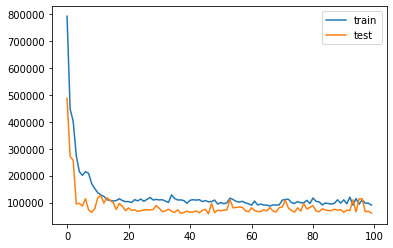

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(X_test)

In [ ]:
rmse = sqrt(mean_squared_error(yhat, y_test))

iknow


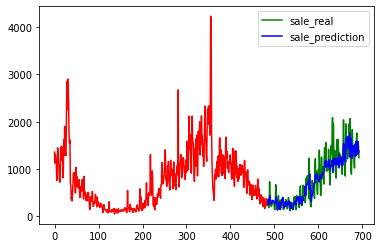

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(0, 485), y_train, color = 'red')
plt.plot(range(485, 485 + 208), y_test, color = 'green', label = 'sale_real')
plt.plot(range(485, 485 + 208),yhat, color = 'blue', label = 'sale_prediction')
plt.legend()
plt.show()

In [ ]:
y_test.shape

(208,)

In [ ]:
model_3 = Sequential()
model_3.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model_3.add(LSTM(64, return_sequences = True))
model_3.add(LSTM(64, return_sequences = False))
model_3.add(Dense(64))
model_3.add(Dense(32))
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model_3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 7, 128)            70144     
_________________________________________________________________
lstm_30 (LSTM)               (None, 7, 64)             49408     
_________________________________________________________________
lstm_31 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 158,849
Trainable params: 158,849
Non-trainable params: 0
_______________________________________________

In [ ]:
history_3 = model_3.fit(X_train, y_train, epochs = 100, batch_size = 7, validation_data = (X_test, y_test), shuffle = False)

Epoch 1/100
70/70 [==============================] - 9s 37ms/step - loss: 892322.1171 - val_loss: 521108.1250
Epoch 2/100
70/70 [==============================] - 1s 16ms/step - loss: 541774.0515 - val_loss: 272107.0312
Epoch 3/100
70/70 [==============================] - 1s 16ms/step - loss: 402888.7795 - val_loss: 272823.0000
Epoch 4/100
70/70 [==============================] - 1s 17ms/step - loss: 468323.3658 - val_loss: 262817.2188
Epoch 5/100
70/70 [==============================] - 1s 16ms/step - loss: 302754.5251 - val_loss: 116921.8672
Epoch 6/100
70/70 [==============================] - 1s 16ms/step - loss: 242452.5821 - val_loss: 238725.9688
Epoch 7/100
70/70 [==============================] - 1s 18ms/step - loss: 264593.5037 - val_loss: 100942.4297
Epoch 8/100
70/70 [==============================] - 1s 17ms/step - loss: 219164.6914 - val_loss: 95284.0469
Epoch 9/100
70/70 [==============================] - 1s 16ms/step - loss: 197622.2647 - val_loss: 88638.4688
Epoch 10/100

In [ ]:
gru_1 = Sequential()
gru_1.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_1.add(Dense(1))
gru_1.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
gru_1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                9000      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params: 9,051
Trainable params: 9,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_history = gru_1.fit(X_train, y_train, epochs = 100, batch_size = 7, validation_data = (X_test, y_test), shuffle = False)

Epoch 1/100
70/70 [==============================] - 4s 18ms/step - loss: 935357.0427 - val_loss: 885159.3750
Epoch 2/100
70/70 [==============================] - 0s 6ms/step - loss: 931294.5977 - val_loss: 880104.6875
Epoch 3/100
70/70 [==============================] - 0s 6ms/step - loss: 926651.2786 - val_loss: 876223.6250
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 923075.3371 - val_loss: 872431.0000
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 919090.3974 - val_loss: 866793.9375
Epoch 6/100
70/70 [==============================] - 0s 5ms/step - loss: 913916.9960 - val_loss: 862334.2500
Epoch 7/100
70/70 [==============================] - 0s 6ms/step - loss: 909761.4886 - val_loss: 858532.3750
Epoch 8/100
70/70 [==============================] - 0s 6ms/step - loss: 906178.5013 - val_loss: 854856.3125
Epoch 9/100
70/70 [==============================] - 0s 6ms/step - loss: 902706.4784 - val_loss: 851259.9375
Epoch 10/100
70/70

In [ ]:
gru_2 = Sequential()
gru_2.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
gru_2.add(GRU(64, return_sequences = False))
gru_2.add(Dense(64))
gru_2.add(Dense(64))
gru_2.add(Dense(1))
gru_2.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
gru_2.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_17 (GRU)                 (None, 7, 128)            52992     
_________________________________________________________________
gru_18 (GRU)                 (None, 64)                37248     
_________________________________________________________________
dense_52 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 65        
Total params: 94,465
Trainable params: 94,465
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_2_history = gru_2.fit(X_train, y_train, epochs = 500, batch_size = 7, validation_data = (X_test, y_test), shuffle = False)

Epoch 1/500
70/70 [==============================] - 1s 13ms/step - loss: 103359.4766 - val_loss: 66060.5938
Epoch 2/500
70/70 [==============================] - 1s 12ms/step - loss: 101104.3750 - val_loss: 66165.2344
Epoch 3/500
70/70 [==============================] - 1s 12ms/step - loss: 97390.0938 - val_loss: 76563.6719
Epoch 4/500
70/70 [==============================] - 1s 13ms/step - loss: 102239.5469 - val_loss: 69010.9766
Epoch 5/500
70/70 [==============================] - 1s 12ms/step - loss: 86660.6875 - val_loss: 84013.7109
Epoch 6/500
70/70 [==============================] - 1s 13ms/step - loss: 101943.1172 - val_loss: 78179.1016
Epoch 7/500
70/70 [==============================] - 1s 13ms/step - loss: 97424.8906 - val_loss: 61885.7969
Epoch 8/500
70/70 [==============================] - 1s 12ms/step - loss: 84199.9375 - val_loss: 60587.8125
Epoch 9/500
70/70 [==============================] - 1s 12ms/step - loss: 87241.3984 - val_loss: 74351.9141
Epoch 10/500
70/70 [====

KeyboardInterrupt: ignored

In [ ]:
gru_3 = Sequential()
gru_3.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = False))
gru_3.add(Dense(128))
gru_3.add(Dense(1))
gru_3.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
gru_3.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_22 (GRU)                 (None, 128)               52992     
_________________________________________________________________
dense_60 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 129       
Total params: 69,633
Trainable params: 69,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_3_history = gru_3.fit(X_train, y_train, epochs = 100, batch_size = 7, validation_data = (X_test, y_test), shuffle = False)

Epoch 1/100
70/70 [==============================] - 3s 15ms/step - loss: 915883.7099 - val_loss: 748011.0625
Epoch 2/100
70/70 [==============================] - 1s 7ms/step - loss: 756648.8292 - val_loss: 473388.8125
Epoch 3/100
70/70 [==============================] - 1s 8ms/step - loss: 516991.8983 - val_loss: 289913.3438
Epoch 4/100
70/70 [==============================] - 1s 7ms/step - loss: 345791.4065 - val_loss: 174150.2812
Epoch 5/100
70/70 [==============================] - 1s 8ms/step - loss: 242414.3280 - val_loss: 115143.6094
Epoch 6/100
70/70 [==============================] - 1s 7ms/step - loss: 197080.2694 - val_loss: 94422.1719
Epoch 7/100
70/70 [==============================] - 1s 8ms/step - loss: 170543.1308 - val_loss: 83452.8047
Epoch 8/100
70/70 [==============================] - 0s 7ms/step - loss: 161004.5184 - val_loss: 74721.5781
Epoch 9/100
70/70 [==============================] - 0s 7ms/step - loss: 151187.4091 - val_loss: 76778.7891
Epoch 10/100
70/70 [==

In [ ]:
yhat_3 = gru_3.predict(X_test)

In [ ]:
yhat_3.shape

(208, 1)

In [ ]:
gru_4 = Sequential()
gru_4.add(GRU(128, input_shape=(7, 8), return_sequences = True))
gru_4.add(GRU(96, return_sequences = False))

gru_4.add(Dense(64))
gru_4.add(Dense(1))
gru_4.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
gru_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7, 128)            52992     
_________________________________________________________________
gru_1 (GRU)                  (None, 96)                65088     
_________________________________________________________________
dense (Dense)                (None, 64)                6208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 124,353
Trainable params: 124,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_4_history = gru_4.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), shuffle = False)

Epoch 1/100
16/16 [==============================] - 0s 22ms/step - loss: 120646.9844 - val_loss: 79925.8672
Epoch 2/100
16/16 [==============================] - 0s 20ms/step - loss: 102837.1719 - val_loss: 63950.9102
Epoch 3/100
16/16 [==============================] - 0s 21ms/step - loss: 98476.9375 - val_loss: 68735.9062
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 97518.8125 - val_loss: 67919.8359
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 91969.6016 - val_loss: 71301.8047
Epoch 6/100
16/16 [==============================] - 0s 19ms/step - loss: 92372.5469 - val_loss: 72443.6719
Epoch 7/100
16/16 [==============================] - 0s 19ms/step - loss: 91464.9219 - val_loss: 70509.4688
Epoch 8/100
16/16 [==============================] - 0s 19ms/step - loss: 91026.5312 - val_loss: 71255.1406
Epoch 9/100
16/16 [==============================] - 0s 19ms/step - loss: 90589.5625 - val_loss: 70579.8125
Epoch 10/100
16/16 [======

In [ ]:
gru_5 = Sequential()
gru_5.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
gru_5.add(GRU(96, return_sequences = True))
gru_5.add(GRU(64, return_sequences = False))
gru_5.add(Dense(64))
gru_5.add(Dense(1))
gru_5.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
gru_5.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_41 (GRU)                 (None, 7, 128)            52992     
_________________________________________________________________
gru_42 (GRU)                 (None, 7, 96)             65088     
_________________________________________________________________
gru_43 (GRU)                 (None, 64)                31104     
_________________________________________________________________
dense_84 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 65        
Total params: 153,409
Trainable params: 153,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_5_history = gru_5.fit(X_train, y_train, epochs = 500, validation_data = (X_test, y_test), shuffle = False)

Epoch 1/500
16/16 [==============================] - 0s 27ms/step - loss: 62631.6055 - val_loss: 76471.9688
Epoch 2/500
16/16 [==============================] - 0s 23ms/step - loss: 66542.3906 - val_loss: 82884.0781
Epoch 3/500
16/16 [==============================] - 0s 22ms/step - loss: 64471.0391 - val_loss: 76274.3594
Epoch 4/500
16/16 [==============================] - 0s 24ms/step - loss: 70706.2891 - val_loss: 82837.2344
Epoch 5/500
16/16 [==============================] - 0s 24ms/step - loss: 67984.8828 - val_loss: 77511.0156
Epoch 6/500
16/16 [==============================] - 0s 25ms/step - loss: 78575.1953 - val_loss: 78902.0859
Epoch 7/500
16/16 [==============================] - 0s 23ms/step - loss: 66388.9531 - val_loss: 80098.2031
Epoch 8/500
16/16 [==============================] - 0s 23ms/step - loss: 63700.4297 - val_loss: 77123.2109
Epoch 9/500
16/16 [==============================] - 0s 22ms/step - loss: 66134.6875 - val_loss: 78831.2812
Epoch 10/500
16/16 [========